# Solve Navier-Stokes equation with fully implicit Crank-Nicolson timestepping

In [1]:
%matplotlib inline

import numpy as np
import scipy
import matplotlib.pyplot as plt

from pyiga import bspline, assemble, geometry, vis, solvers

In [2]:
# set up the geometry map
geo = geometry.circular_arc(np.pi / 8).rotate_2d(np.pi/2 - np.pi/16).scale([-1,1])
geo = geo.translate(-geo(0))
geo = geo.scale([3 / geo(1)[0], 30])
geo = geometry.outer_sum(geometry.line_segment([0,0], [0,0.5]), geo)

In [3]:
# define geometry
#geo = geometry.unit_square().scale([3,1])

# define isogeometric discretization space (Taylor-Hood like)
p = 2     # spline degree of velocity space
n_el = (30, 120)   # number of elements in y/x direction

kvs_u = tuple(bspline.make_knots(p,   0.0, 1.0, n, mult=1) for n in n_el)
kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el)

m_u = tuple(kv.numdofs for kv in kvs_u)
m_p = tuple(kv.numdofs for kv in kvs_p)
n_u1 = np.prod(m_u)
n_u = 2 * n_u1
n_p = np.prod(m_p)

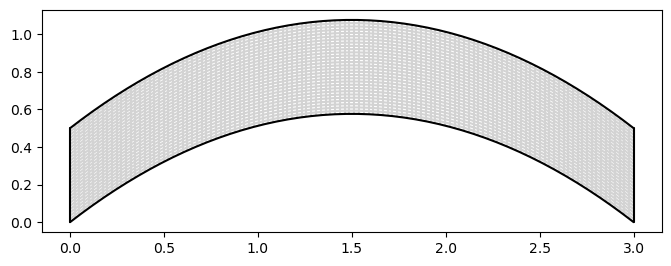

In [4]:
plt.figure(figsize=(8,8))
vis.plot_geo(geo, gridy=n_el[0], gridx=n_el[1], lcolor='lightgray')
plt.axis('scaled');

In [5]:
def get_components(u):
    """Split solution vector into velocity and pressure components."""
    u1 = u[:n_u1].reshape(m_u)
    u2 = u[n_u1:n_u].reshape(m_u)
    U = np.stack((u1,u2), axis=-1)
    prs = u[n_u:].reshape(m_p)
    return bspline.BSplineFunc(kvs_u, U), bspline.BSplineFunc(kvs_p, prs)

def vel_norm(u):
    """Return a function for evaluating the norm of the velocity."""
    vel, pre = get_components(u)
    def f(X, Y):
        V = vel.grid_eval((Y,X))
        return np.linalg.norm(V, axis=-1)
    return f

In [6]:
# Dirichlet boundary conditions
def g_inflow(x, y): return (40*y*(0.5-y)*np.exp(-100*(y-.25)**2), 0.0)
def g_zero(x, y):   return (0.0, 0.0)

bcs = assemble.compute_dirichlet_bcs(kvs_u, geo,
    [ ('bottom', g_zero), ('top', g_zero), ('left', g_inflow) ]                                     
)

In [7]:
# Reynolds number
Re = 1e4

# time step
tau = 2e-2

In [8]:
# assemble Stokes problem
A_grad = assemble.assemble('inner(grad(u), grad(v)) * dx', kvs_u, bfuns=[('u',2), ('v',2)], geo=geo)
A_div  = assemble.assemble('div(u) * p * dx', (kvs_u, kvs_p), bfuns=[('u',2,0), ('p',1,1)], geo=geo)
M_pre = assemble.mass(kvs_p, geo)
M_vel = assemble.mass(kvs_u, geo)

M_vel_full = scipy.sparse.bmat(
    [[M_vel, None, None  ],
     [None, M_vel, None  ],
     [None, None, scipy.sparse.csr_matrix((n_p,n_p))]], format='csr')

A_stokes = scipy.sparse.bmat(
    [[Re**-1*A_grad, A_div.T],
     [A_div,     1e-10*M_pre]], format='csr')

In [9]:
LS = assemble.RestrictedLinearSystem(A_stokes, 0.0, bcs)

In [11]:
solvers.make_solver(LS.A, symmetric=True)

KeyboardInterrupt: 

In [ ]:
# compute initial value from Stokes equation
LS = assemble.RestrictedLinearSystem(A_stokes, 0.0, bcs)
u = LS.complete(solvers.make_solver(LS.A)@LS.b)
solutions = [LS.restrict(u)]

In [49]:
# set up nonlinear and linearized N-S system
vel, pre = get_components(u)

# nonlinear convection term (functional)
asm_nlconv = assemble.Assembler('grad(vel).dot(vel).dot(v) * dx', kvs_u,
                    bfuns=[('v',2)], geo=geo, vel=vel, updatable=['vel'])
# linearized convection term by freezing velocity (matrix)
asm_linconv = assemble.Assembler('grad(u).dot(vel).dot(v) * dx', kvs_u,
                    bfuns=[('u',2), ('v',2)], geo=geo, vel=vel, updatable=['vel'])

def apply_nl_conv(vel):
    z = asm_nlconv.assemble(vel=vel)
    return np.concatenate((z.ravel(), np.zeros(n_p)))

def apply_navier_stokes(u_p):
    vel, pre = get_components(u_p)
    return apply_nl_conv(vel) + A_stokes.dot(u_p)

def linearized_ns(u_p):
    vel, pre = get_components(u_p)
    A_linconv = asm_linconv.assemble(vel=vel)
    A_lns = scipy.sparse.bmat(
        [[Re**-1*A_grad + A_linconv, A_div.T],
         [A_div,                 1e-10*M_pre]],
        format='csr')
    return A_lns

In [50]:
# set up DAE for instationary Navier-Stokes
def ns_F(x):
    u_p = LS.complete(x)
    return -LS.restrict(apply_navier_stokes(u_p))
def ns_J(x):
    u_p = LS.complete(x)
    return -LS.restrict_matrix(linearized_ns(u_p))
ns_M = LS.restrict_matrix(M_vel_full)

In [51]:
t_end = 3.0

time_steps = solvers.rowdaind2(ns_M, ns_F, ns_J, solutions[-1], tau, t_end, tol=1e-2, progress=True)
solutions.extend(time_steps[1][1:])



  0%|                                                   | 0/3.0 [00:00<?, ?it/s]

  1%|▎                                       | 0.02/3.0 [00:00<00:23,  7.79s/it]

  1%|▏                             | 0.02/3.0 [00:00<00:23,  7.79s/it, tau=0.02]

  2%|▎              | 0.06809258012828141/3.0 [00:00<00:11,  4.04s/it, tau=0.02]

  2%|▎            | 0.06809258012828141/3.0 [00:00<00:11,  4.04s/it, tau=0.0481]

  4%|▌            | 0.12749338084139505/3.0 [00:00<00:08,  3.05s/it, tau=0.0481]

  4%|▌            | 0.12749338084139505/3.0 [00:00<00:08,  3.05s/it, tau=0.0594]

  6%|▊            | 0.18528900911164933/3.0 [00:00<00:07,  2.78s/it, tau=0.0594]

  6%|▊            | 0.18528900911164933/3.0 [00:00<00:07,  2.78s/it, tau=0.0578]

  8%|█            | 0.24341469779937702/3.0 [00:00<00:07,  2.64s/it, tau=0.0578]

  8%|█            | 0.24341469779937702/3.0 [00:00<00:07,  2.64s/it, tau=0.0581]

 10%|█▎           | 0.30291846985406834/3.0 [00:00<00:06,  2.51s/it, tau=0.0581]

 10%|█▎       

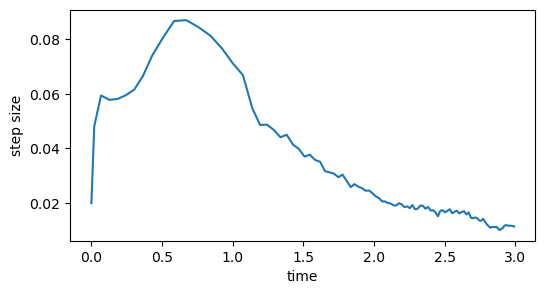

In [52]:
# plot history of step sizes
plt.figure(figsize=(6,3))
times = np.array(time_steps[0])
stepsizes = times[1:] - times[:-1]
plt.plot(times[:-1], stepsizes);
plt.xlabel('time'); plt.ylabel('step size');

In [53]:
T_anim = np.linspace(0, 3, 200)   # animation timesteps
# interpolate adaptive solution at the animation frame times
sol_interp = scipy.interpolate.interp1d(time_steps[0],
                [LS.complete(uu) for uu in time_steps[1]], axis=0)
fields = [vel_norm(sol_interp(tt)) for tt in T_anim]

  0%|                                                   | 0/200 [01:49<?, ?it/s]
201it [00:24,  8.31it/s]                                                        


<Figure size 1400x400 with 0 Axes>

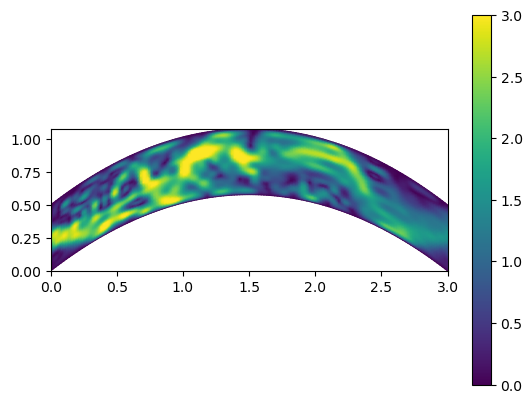

In [54]:
from IPython.display import HTML

plt.figure(figsize=(14, 4))
#fields = [vel_norm(LS.complete(uu)) for uu in solutions]
HTML(vis.animate_field(fields, geo, res=(50, 150), vrange=(0,3), interval=35, progress=True).to_html5_video())

In [56]:
xgrid = np.linspace(0, 1, 200)
xygrid = (xgrid, xgrid)

velocity, pressure = get_components(LS.complete(solutions[-1]))

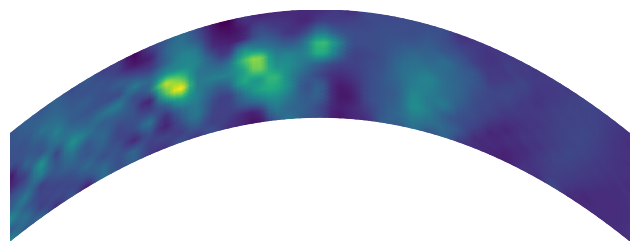

In [58]:
plt.figure(figsize=(8,3))
plt.axis('off')
vis.plot_field(pressure, geo);